In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils

In [29]:
def shi_tomashi(image):
    """
    Use Shi-Tomashi algorithm to detect corners
    Args:
        image: np.array
    Returns:
        corners: list
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 4, 0.01, 100)
    corners = np.int0(corners)
    corners = sorted(np.concatenate(corners).tolist())
    print('\nThe corner points are...\n')

    im = image.copy()
    for index, c in enumerate(corners):
        x, y = c
        cv2.circle(im, (x, y), 3, 255, -1)
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(im, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

    plt.imshow(im)
    plt.title('Corner Detection: Shi-Tomashi')
    plt.show()
    return corners

In [32]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

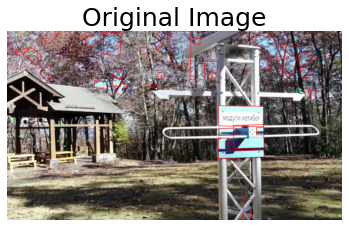

In [46]:
image = cv2.imread('mast_imgs/frame_40.jpg')
 
# Converting the image to hsv
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
lower_red = np.array([60,35,140])
upper_red = np.array([180,255,255])
     
mask = cv2.inRange(hsv, lower_red, upper_red)

cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
if len(cnts)>0:
    curr_boxes = []
    for (i, c) in enumerate(cnts):
        if (cv2.contourArea(c) < 500):
            continue
        #print(cv2.contourArea(c))
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        cv2.drawContours(image, [box], -1, (0, 0, 255), 2)

        rect = order_points(box)
        center = ((rect[0][1] + rect[1][1] + rect[2][1] + rect[3][1])/4, (rect[0][0] + rect[1][0] + rect[2][0] + rect[3][0])/4)
        colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))

        cv2.circle(image, (int(center[0]), int(center[1])) , 5, (0, 255, 0), -1)
    
result = cv2.bitwise_and(image, image, mask = mask)

#edges = cv2.Canny(result, 50, 200)


#plt.figure(figsize=[13,13])

#plt.subplot(141);
plt.imshow(image[:,:,::-1]);plt.title("Original Image",fontdict={'fontsize': 25});plt.axis('off');
#plt.subplot(142);
#plt.imshow(mask, cmap='gray');plt.title("Mask of blue Color",fontdict={'fontsize': 25});plt.axis('off');
#plt.subplot(143);plt.imshow(result[:,:,::-1]);plt.title("Result Image",fontdict={'fontsize': 25});plt.axis('off');

#plt.subplot(144),
#plt.imshow(edges,cmap = 'gray')


